In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential 
from keras.layers import Dense,LSTM,Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real AMZN Stock Price')
    plt.plot(predicted, color='blue',label='Predicted AMZN Stock Price')
    plt.title('AMZN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMZN Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
dataset = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()
dataset.shape

(3019, 6)

In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
training_set.shape
test_set.shape

(251, 1)

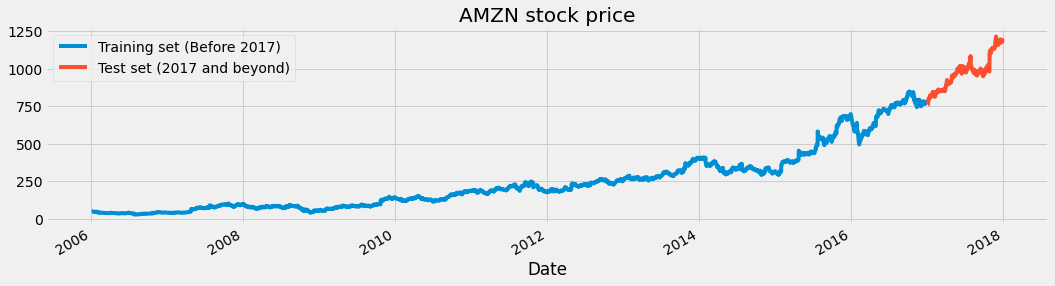

In [6]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('AMZN stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train.shape

(2708, 60)

In [10]:
y_train.shape

(2708,)

In [11]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [12]:
X_train.shape

(2708, 60, 1)

In [13]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')



# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
85/85 [==============================] - 7s 85ms/step - loss: 0.0100
Epoch 2/5
85/85 [==============================] - 8s 99ms/step - loss: 0.0042
Epoch 3/5
85/85 [==============================] - 9s 103ms/step - loss: 0.0035
Epoch 4/5
85/85 [==============================] - 9s 101ms/step - loss: 0.0027
Epoch 5/5
85/85 [==============================] - 8s 98ms/step - loss: 0.0026


In [14]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [15]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

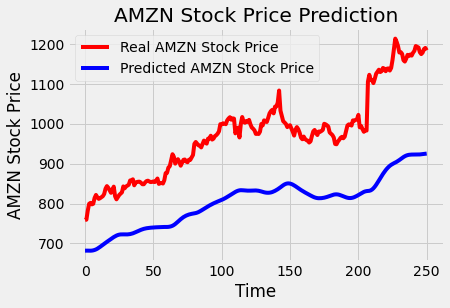

In [16]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)